# Image enhancement

In [0]:
#@title Imports
import numpy as np
from scipy.misc import face
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import cv2 as cv
from google.colab.patches import cv2_imshow
from PIL import Image
import requests
from io import BytesIO

## Intensity transformations (no code)

They are necessary, for instance, when the main figure in a picture is well lit but the background is not. In this case, we map each pixel value to another one via a function, a pointwise operation. This transformation can modify the dynamic range of the codification in many ways:
1. **inverse log**: ; it compresses most of the range ($\frac{3}{4}$ of it and expands the last quarter
1. $\mathbf{n}$**th power**: it behaves similarly to the inverse log, but possibly less drastically
1. $\mathbf{n}$**th root**: it is similar to the logarithmic curve but softer
1. **log**: $c \cdot log(r+1)$; expands the first quarter and compresses the remaining three
1. **negative**: $s=L-r$; maps $[0,L]$ to $[L,0]$ in a descending order
1. **exponential**: $c \cdot r^\gamma$; this is also known as **gamma correction**, necessary in some monitors; it is also used to _stretch_ the range

Notably, all of these transformations are reversible. No information is lost.

## Histogram equalization

The histogram is exactly the same as in probability and statistics: it shows the density of a discrete random variable. In this case, the RV is the pixel value.

An easy way to think of a good output histogram is an uniform one. If the image we want to equalize has high density in low values and low density in middle and high ones, equalizing it, aiming to turn it into an uniform distribution, will spread the values over the dynamic range.

Transformations applied in histogram equalization will be monotonically increasing. We would like for them to be bijective maps, but in reality it is not possible.

The formula to perform the histogram equalization on histogram $p_r(r)$ is:

$$ s = \mathcal{T}(r) = (L-1) \int_0^r p_r(\omega) \, \partial \omega $$

Note that the integral, as a conceptual summation in the infinitesimal limit, is a monotonic transformation (for positive/null summands). Given the change of variables in probabilities:

$$ P_S(s) = P_R(r) \cdot \left| \frac{\partial r}{\partial s} \right| $$

If we calculate the inverse of that derivative:

$$ \frac{\partial s}{\partial r} = \frac{\partial \mathcal{T}(r)}{\partial r} = \frac{\partial (L-1) \int_0^r p_r(\omega) \, \partial \omega}{\partial r} $$
$$ = (L-1) \cdot p_r(r) $$

Replacing this as the inverse of the derivative in the change of variables formula:

$$ p_s(s) = p_r(r) \cdot \left| \frac{1}{(L-1) \cdot p_r(r)} \right| = \frac{p_r(r)}{(L-1) \cdot p_r(r)} = \frac{1}{L-1} $$

And that is the definition of the uniform distribution for pixel values in the range $[0,L]$.

It must be noted that, as computers deal with discrete values, if the transformation maps the input value to a real one, we will have to round it, which introduces noise.

### In code

#### Simple histogram equalization

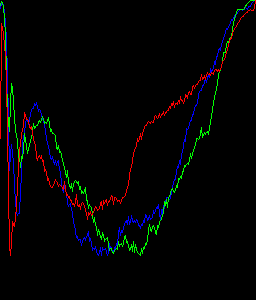

In [3]:
#@title Image 1
# img = cv.imread('image.jpg')
img1 = face(gray=False)
plt.imshow(img1)
plt.axis('off')
plt.show()

h = np.zeros((300,256,3))

bins = np.arange(256).reshape(256,1)
color = [ (255,0,0),(0,255,0),(0,0,255) ]

for ch, col in enumerate(color):
    hist_item = cv.calcHist([img1], [ch], None, [256], [0, 255])
    cv.normalize(hist_item, hist_item, 0, 255, cv.NORM_MINMAX)
    hist = np.int32(np.around(hist_item))
    pts = np.column_stack((bins, hist))
    cv.polylines(h, [pts], False, col)
    
    # h=np.flipud(h)

cv2_imshow(h)
# cv.waitKey(0)

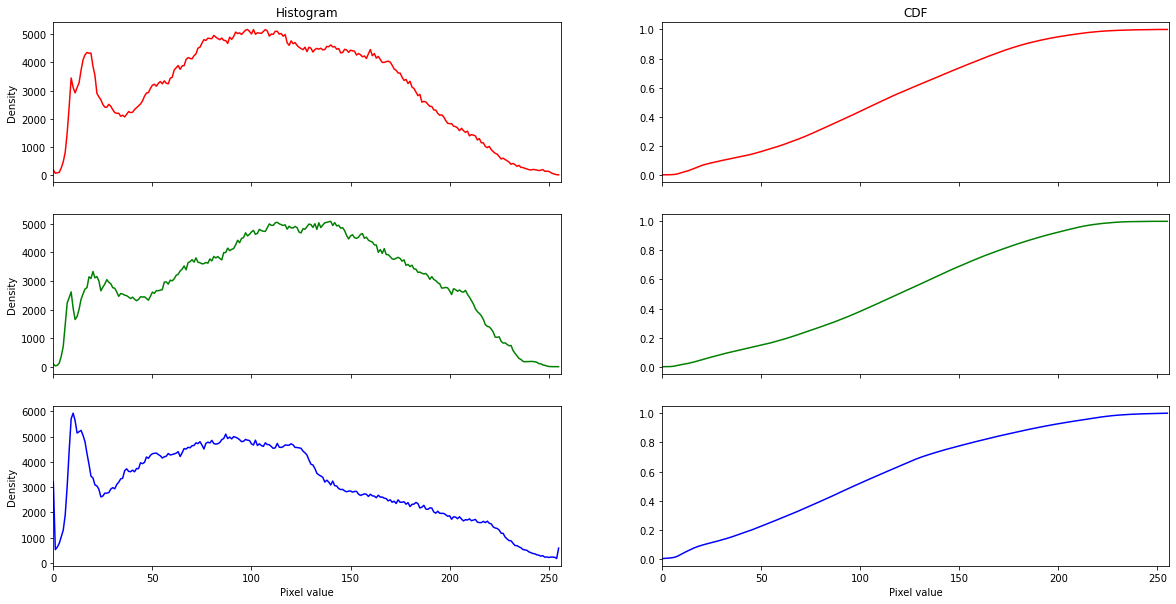

In [4]:
#@title Histograms and CDFs
hist1 = np.zeros((256, 3))

# Normalized histogram
# hist1[:,0], binsr = np.histogram(img1[:,:,0].flatten(), 256, [0, 256], density=True)
# hist1[:,1], binsg = np.histogram(img1[:,:,1].flatten(), 256, [0, 256], density=True)
# hist1[:,2], binsb = np.histogram(img1[:,:,2].flatten(), 256, [0, 256], density=True)

# Non-normalized histogram
hist1[:,0], binsr = np.histogram(img1[:,:,0].flatten(), 256, [0, 256], density=False)
hist1[:,1], binsg = np.histogram(img1[:,:,1].flatten(), 256, [0, 256], density=False)
hist1[:,2], binsb = np.histogram(img1[:,:,2].flatten(), 256, [0, 256], density=False)

cdf1 = np.zeros((256, 3))
cdf1[:,0] = hist1[:,0].cumsum()
cdf1[:,1] = hist1[:,1].cumsum()
cdf1[:,2] = hist1[:,2].cumsum()

plt.figure(figsize=(20, 10))
for c in range(3):
    plt.subplot(3, 2, 2*c+1)
    plt.plot(hist1[:,c], ['r','g','b'][c])
    plt.xlim([0,256])
    plt.ylabel('Density')
    if c == 0: plt.title("Histogram")
    if c < 2:
        plt.tick_params(labelbottom=False)
    else:
        plt.xlabel('Pixel value')
    
    plt.subplot(3, 2, 2*(c+1))
    plt.plot(cdf1[:,c]/cdf1[:,c].max(), ['r-','g-','b-'][c])
    plt.xlim([0,256])
    if c == 0: plt.title('CDF')
    if c < 2:
        plt.tick_params(labelbottom=False)
    else:
        plt.xlabel('Pixel value')
plt.show()

In [0]:
#@title Equalization process
scale = 0.5 #@param {type:"slider", min:0, max:1, step:0.01}

cdf1_mask = np.ma.zeros((256, 3))
equalize1 = np.ma.zeros((256, 3))

for c in range(3):
    cdf1_mask[:, c] = np.ma.masked_equal(cdf1[:,c], 0)
    cdf1_mask[:, c] = (cdf1_mask[:, 0] - cdf1_mask[:, 0].min()) * 255 / (cdf1_mask[:, 0].max() - cdf1_mask[:, 0].min())
    equalize1[:, c] = np.ma.filled(cdf1_mask[:, c], 0).astype('uint8')

img1_eq = np.zeros_like(img1)
hist1_eq = np.zeros((256, 3))
for c in range(3):
    img1_eq[:,:,c] = scale * equalize1[:, c][img1[:,:,c]] + (1-scale) * img1[:,:,c]
    hist1_eq[:,c], _ = np.histogram(img1_eq[:,:,c].flatten(), 256, [0, 256])

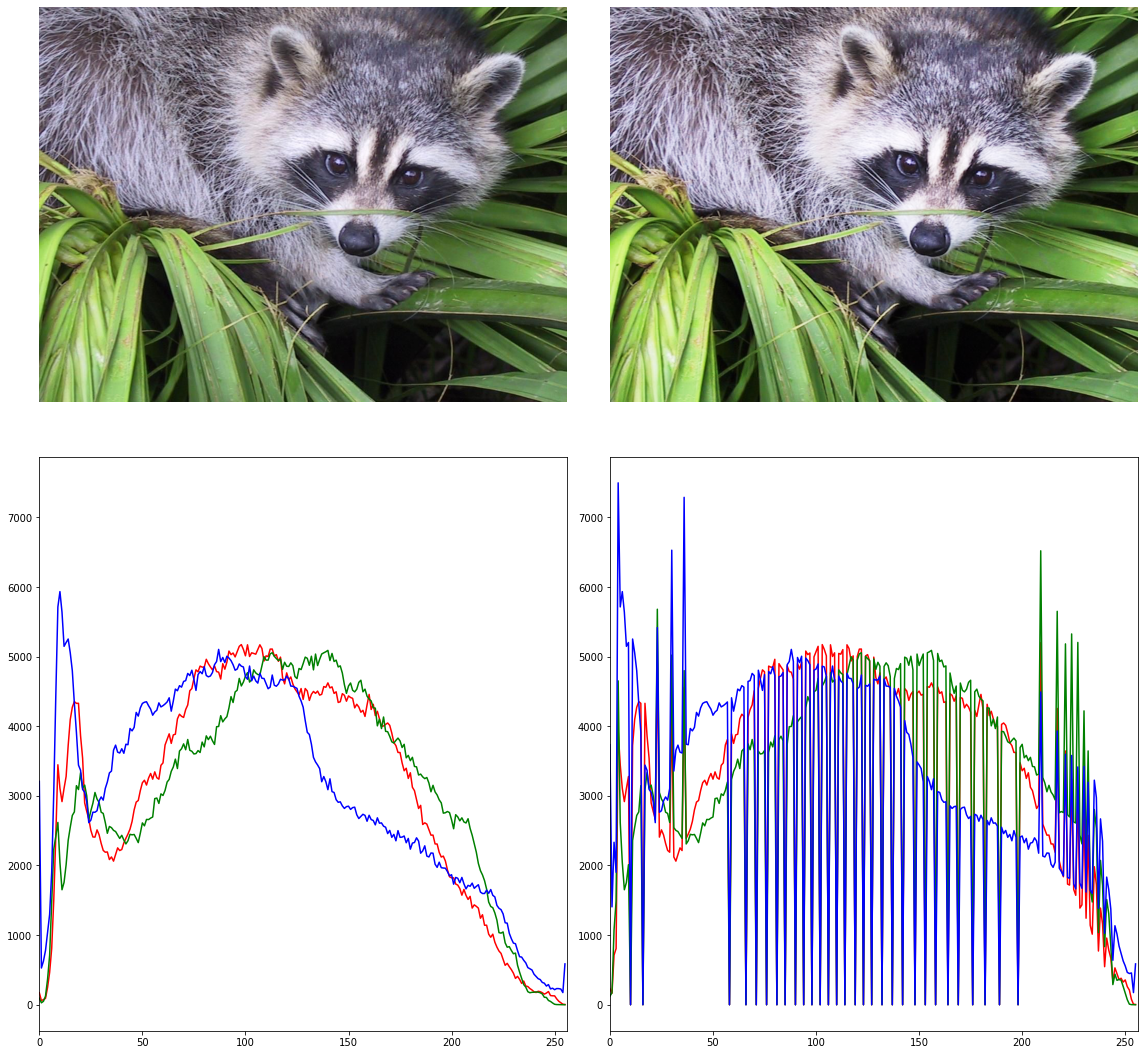

In [6]:
#@title Plotting
plt.figure(figsize=(16, 16))
plt.subplot(221)
plt.imshow(img1)
plt.axis('off')
plt.subplot(222)
plt.imshow(img1_eq)
plt.axis('off')
ax1 = plt.subplot(223)
ax1.plot(hist1[:,0], 'r', hist1[:,1], 'g', hist1[:,2], 'b')
ax1.set_xlim((0, 256))
ax2 = plt.subplot(224, sharey=ax1)
ax2.plot(hist1_eq[:,0], 'r', hist1_eq[:,1], 'g', hist1_eq[:,2], 'b')
ax2.set_xlim((0, 256))
plt.tight_layout()
plt.show()

#### Contrast-Limited Adaptive Histogram Equalization (CLAHE)

First, the image is divided in a tile grid, just like in JPEG compression. The histogram is computed for each block in the image but, before applying the transformation map, the histogram is clipped both in the less frequent values and in the most frequent ones. The cumulative density function is calculated on this modified histogram, and it is the one used to map de pixel values on each block to the new ones.

More efficient implementations interpolate the values of the blocks with those surrounding them, or use a sliding window.

##### CLAHE on RGB

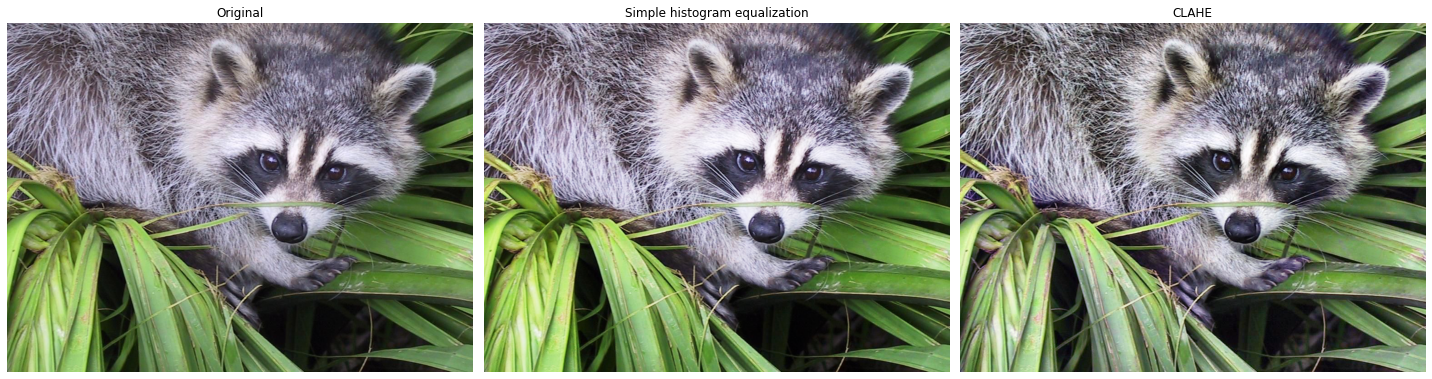

In [7]:
#@title CLAHE on RGB
clipLimit = 1 #@param {type:"slider", min:0, max:5, step:0.1}

clahe = cv.createCLAHE(clipLimit=clipLimit, tileGridSize=(8, 8))
img1_eq_clahe_rgb = np.zeros_like(img1)

for c in range(3):
    img1_eq_clahe_rgb[:,:,c] = clahe.apply(img1[:,:,c].astype('uint8'))

plt.figure(figsize=(20,10))

plt.subplot(131)
plt.title("Original")
plt.imshow(img1)
plt.axis('off')

plt.subplot(132)
plt.title("Simple histogram equalization")
plt.imshow(img1_eq)
plt.axis('off')

plt.subplot(133)
plt.title('CLAHE')
plt.imshow(img1_eq_clahe_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()

##### CLAHE on YCbCr

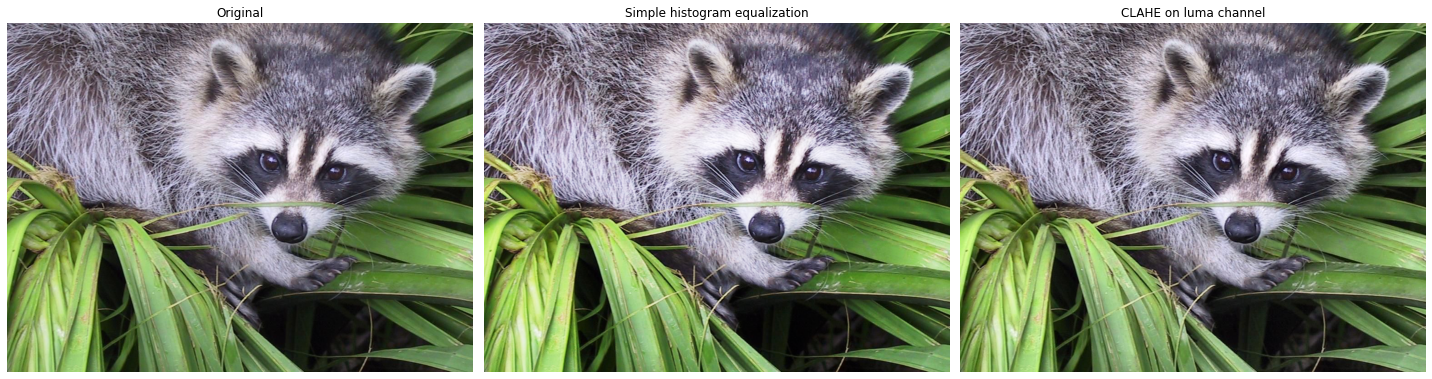

In [30]:
#@title CLAHE on luma channel only
clipLimit = 0.5 #@param {type:"slider", min:0, max:5, step:0.1}
clahe = cv.createCLAHE(clipLimit=clipLimit, tileGridSize=(8, 8))
img1_eq_clahe_ycbcr = cv.cvtColor(img1, cv.COLOR_RGB2YCrCb)  # [:,:,::-1] COLOR_BGR2YCR_CB
# img1_eq_clahe_ycbcr = np.zeros_like(img1_ycbcr)

# for c in range(3):
#     img1_eq_clahe_ycbcr[:,:,c] = clahe.apply(img1_ycbcr[:,:,c].astype('uint8'))

img1_eq_clahe_ycbcr[:,:,0] = clahe.apply(img1_ycbcr[:,:,0])
img1_eq_clahe_ycbcr = cv.cvtColor(img1_eq_clahe_ycbcr, cv.COLOR_YCrCb2RGB)  # [:,:,::-1] COLOR_YCR_CB2BGR

plt.figure(figsize=(20,10))

plt.subplot(131)
plt.title("Original")
plt.imshow(img1)
plt.axis('off')

plt.subplot(132)
plt.title("Simple histogram equalization")
plt.imshow(img1_eq)
plt.axis('off')

plt.subplot(133)
plt.title('CLAHE on luma channel')
plt.imshow(img1_eq_clahe_ycbcr)
plt.axis('off')

plt.tight_layout()
plt.show()

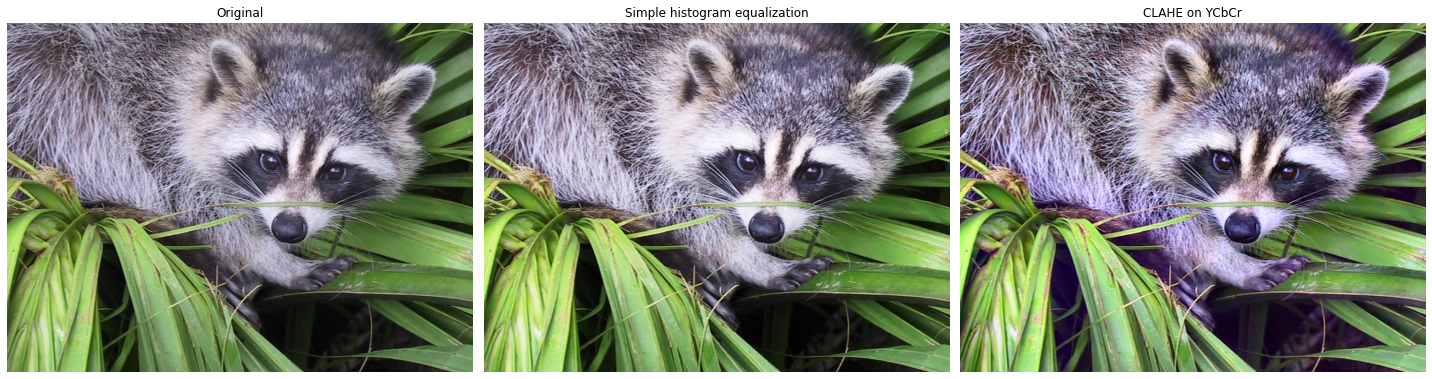

In [32]:
#@title CLAHE on whole YCbCr
clipLimit_Y = 1.6 #@param {type:"slider", min:0.0, max:5.0, step:0.1}
clipLimit_C = 0.6 #@param {type:"slider", min:0.0, max:5.0, step:0.1}
clahe = cv.createCLAHE(clipLimit=1.0, tileGridSize=(8, 8))
img1_eq_clahe_ycbcr = cv.cvtColor(img1, cv.COLOR_RGB2YCrCb)

# Transform
img1_eq_clahe_ycbcr[:,:,0] = clahe.apply(img1_ycbcr[:,:,0])  # only on luma
for c in range(1, 3):  # only on chroma
    img1_eq_clahe_ycbcr[:,:,c] = clahe.apply(img1_ycbcr[:,:,c].astype('uint8'))
img1_eq_clahe_ycbcr = cv.cvtColor(img1_eq_clahe_ycbcr, cv.COLOR_YCrCb2RGB)

plt.figure(figsize=(20,10))

plt.subplot(131)
plt.title("Original")
plt.imshow(img1)
plt.axis('off')

plt.subplot(132)
plt.title("Simple histogram equalization")
plt.imshow(img1_eq)
plt.axis('off')

plt.subplot(133)
plt.title('CLAHE on YCbCr')
plt.imshow(img1_eq_clahe_ycbcr)
plt.axis('off')

plt.tight_layout()
plt.show()

## Histogram matching

When we know what we want the output histogram to look like (other than an uniform one), the process required to morph the input histogram into this target is called histogram matching. We need to find a map that does that.

We start from the distribution of the input image, which we then map to the uniform distribution. We can do the same for the target distribution, so inverting this map and chaining it after the first one we get a composed transformation that goes from the input to the target histogram.

There is a caveat: the maps end up not being one-to-one, which loses information. A common practice when many values end up in the same output value is to pick the output value the closest to the original one.

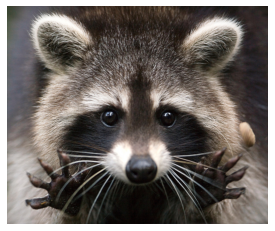

In [58]:
#@title Image 2
url = 'https://www.occasionalplanet.org/wp-content/uploads/2014/08/Raccoon2.jpg'
response = requests.get(url)
img2 = np.asarray(Image.open(BytesIO(response.content)))
plt.imshow(img2)
plt.axis('off')
plt.show()

h = np.zeros((300, 256, 3))

bins = np.arange(256).reshape(256,1)
color = [(255,0,0), (0,255,0), (0,0,255)]

for ch, col in enumerate(color):
    hist_item = cv.calcHist([img2], [ch], None, [256], [0, 255])
    cv.normalize(hist_item, hist_item, 0, 255, cv.NORM_MINMAX)
    hist2 = np.int32(np.around(hist_item))
    pts = np.column_stack((bins, hist2))
    cv.polylines(h, [pts], False, col)
    
    # h=np.flipud(h)
    # cv.waitKey(0)
cv2_imshow(h)

In [59]:
#@title Histograms
hist2 = np.zeros((256,3))

# Normalized histogram
# hist2[:,0], binsr = np.histogram(img2[:,:,0].flatten(), 256, [0, 256], density=True)
# hist2[:,1], binsg = np.histogram(img2[:,:,1].flatten(), 256, [0, 256], density=True)
# hist2[:,2], binsb = np.histogram(img2[:,:,2].flatten(), 256, [0, 256], density=True)

# Non-normalized histogram
hist2[:,0], binsr = np.histogram(img2[:,:,0].flatten(), 256, [0, 256], density=False)
hist2[:,1], binsg = np.histogram(img2[:,:,1].flatten(), 256, [0, 256], density=False)
hist2[:,2], binsb = np.histogram(img2[:,:,2].flatten(), 256, [0, 256], density=False)

# Cumulative Density Functions
cdf2 = np.zeros((256, 3))
cdf2[:,0] = hist2[:,0].cumsum()
cdf2[:,1] = hist2[:,1].cumsum()
cdf2[:,2] = hist2[:,2].cumsum()

# Plotting
plt.figure(figsize=(20, 10))
for c in range(3):
    plt.subplot(3, 2, 2*c+1)
    plt.plot(hist2[:,c], ['r','g','b'][c])
    plt.xlim([0,256])
    plt.ylabel('Density')
    if c == 0: plt.title("Histogram")
    if c < 2:
        plt.tick_params(labelbottom=False)
    else:
        plt.xlabel('Pixel value')
    
    plt.subplot(3, 2, 2*(c+1))
    plt.plot(cdf2[:,c]/cdf2[:,c].max(), ['r-','g-','b-'][c])
    plt.xlim([0,256])
    if c == 0: plt.title('CDF')
    if c < 2:
        plt.tick_params(labelbottom=False)
    else:
        plt.xlabel('Pixel value')
plt.show()

In [0]:
#@title Equalization process
scale = 0.51 #@param {type:"slider", min:0, max:1, step:0.01}

cdf2_mask = np.ma.zeros((256, 3))
equalize2 = np.ma.zeros((256, 3))
equalize_total = np.zeros((256, 3))
match_map1 = [[]] * 3
match_map2 = [[]] * 3

# Transformation calculation
for c in range(3):
    # CDF1
    normalized_cdf1_c = cdf1[:, c] / cdf1[:, c].max()
    # Inversion of img1 equalization: from uniform to original histogram
    match_map1[c] = interp1d(normalized_cdf1_c * 255, np.arange(256), fill_value='extrapolate')
    # CDF2
    normalized_cdf2_c = cdf2[:, c] / cdf2[:, c].max()
    # img2 equalization: from original histogram to uniform
    match_map2[c] = interp1d(np.arange(256), normalized_cdf2_c * 255, fill_value='extrapolate')

# match_map = [lambda x: match_map1[c](match_map2[c](x[:,:,c])) for c in range(2)]

img2_matched = np.zeros_like(img2)
hist2_matched = np.zeros((256, 3))

for c in range(3):
    # transform: from original img2 histogram to uniform, then to img1 histogram
    img2_matched[:,:,c] = scale * match_map1[c](match_map2[c](img2[:,:,c])) + (1-scale) * img2[:,:,c]
    hist2_matched[:,c], _ = np.histogram(img2_matched[:,:,c].flatten(), 256, [0, 256])

# img2_matched = scale * match_map(img2) + (1-scale) * img2  # check if lambdas work
# for c in range(3):
#     hist2_matched[:,c], _ = np.histogram(img2_eq[:,:,c].flatten(), 256, [0, 256])

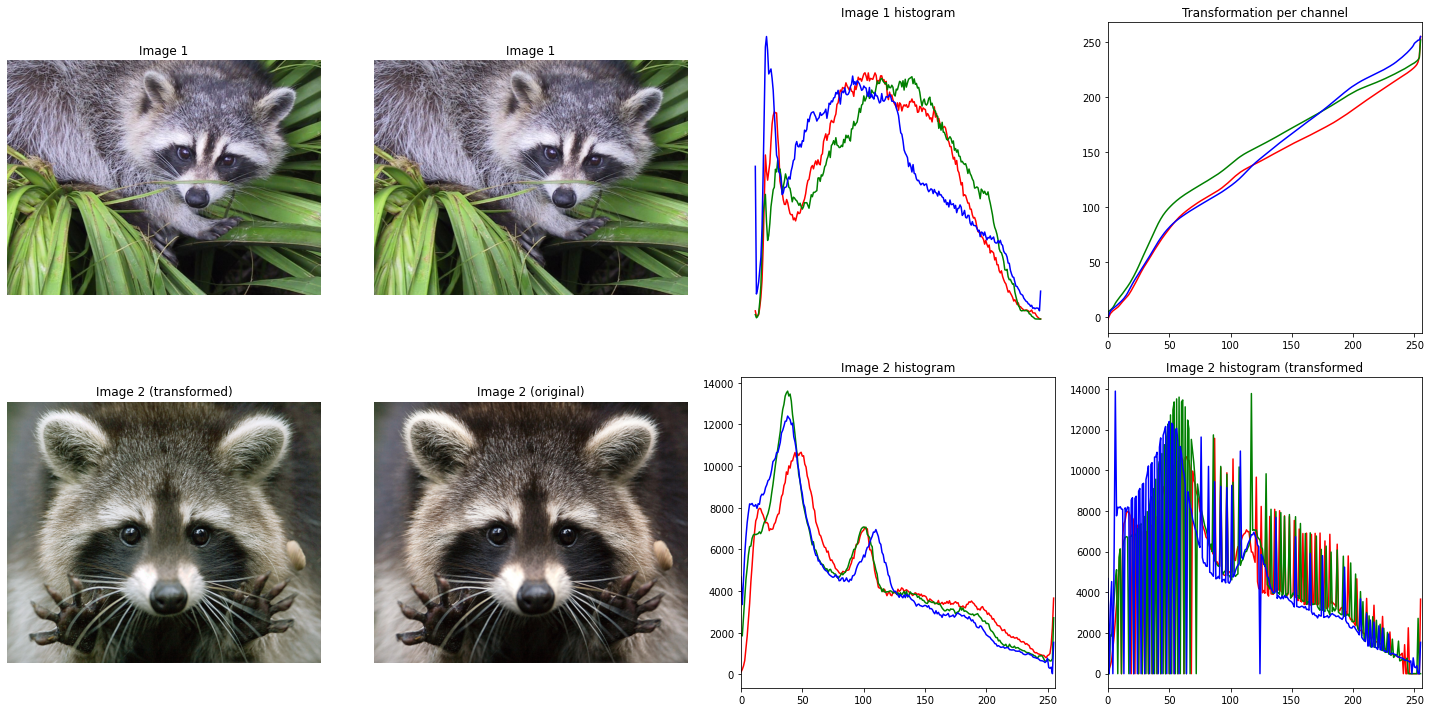

In [67]:
#@title Plotting
plt.figure(figsize=(20, 10))

plt.subplot(241)
plt.title('Image 1')
plt.imshow(img1)
plt.axis('off')

plt.subplot(242)
plt.title('Image 1')
plt.imshow(img1)
plt.axis('off')

plt.subplot(243)
plt.title("Image 1 histogram")
plt.plot(hist1[:,0], 'r', hist1[:,1], 'g', hist1[:,2], 'b')
plt.axis('off')

plt.subplot(244)
plt.title("Transformation per channel")
plt.plot(match_map1[0](match_map2[0](np.arange(256))), 'r',
         match_map1[1](match_map2[1](np.arange(256))), 'g',
         match_map1[2](match_map2[2](np.arange(256))), 'b')
plt.xlim((0, 256))

plt.subplot(245)
plt.title("Image 2 (transformed)")
plt.imshow(img2_matched)
plt.axis('off')

plt.subplot(246)
plt.title("Image 2 (original)")
plt.imshow(img2)
plt.axis('off')

plt.subplot(247)
plt.title("Image 2 histogram")
plt.plot(hist2[:,0], 'r', hist2[:,1], 'g', hist2[:,2], 'b')
plt.xlim((0, 256))

plt.subplot(248)
plt.title("Image 2 histogram (transformed")
plt.plot(hist2_matched[:,0], 'r', hist2_matched[:,1], 'g', hist2_matched[:,2], 'b')
plt.xlim((0, 256))

plt.tight_layout()
plt.show()

## Averaging

## Local averaging

The idea of averaging can be developed in the following way. Given a set of pixels $\left\{ p_1, p_2, ..., p_N\right\}$ which are all supposed to have the same value, the will in practice have some noise $\epsilon_i$, which is a random variable. By averaging the pixels, the intensity of the noise (energy?) will go down according to $k \cdot N^2$, namely, proportionally to the square of the number of pixels in the average.

Local averaging lets us get rid of some small disturbances or noise, at the expense of losing definition through blurring. This is because it effectively averages pixels that in reality have no relation and therefore show a value too different.

For the following expression:
$$ min_{wrt\,a} \left[ (a-1)^2 + (a-2)^2 + (a-3)^2 + ... \right]$$
$$ min_{wrt\,a} \left[ \sum_{i=0}^N \left( a - a_i \right)^2 \right] $$
the value that satisfies the minimization is the average of the set of $a_i$. In the second formula, we can see the expression is not different to the Mean Squared Error (MSE). In this way, local averaging can be thought of as the output value that minimizes the mean squared difference among all the surrounding pixels.

__Gaussian filtering__ consists in convolving the input image $f(x,y)$ with a Gaussian kernel $G(0,\sigma)$:

$$ f(x,y,\sigma) = f(x,y) * G(0,\sigma) $$

and recall the __heat flow__ equation:

$$ \frac{\partial f}{\partial t} = \nabla^2 f = \frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2} $$

where $\nabla^2$ is called the Laplacian. This states that heat diffuses in an isotropic medium according to that relation. The interesting part is that the Gaussian kernel satisfies the heat flow equation, if performing the derivative on $\sigma$ instead of $t$, the time.

The analogy would imply that if we let the heat diffuse, the variance $\sigma^2$ would drop and consequently give a smoother, broader kernel for filtering; if we stop the diffusion process, the kernel will instead be sharp and small.

## Non-local means

As opposed to local average, non-local means avoids the image blurring in the averaging process. This is by only averaging elements that are similar, which in practice can be done in a wide variety of fashions.

What non-local means propose is: to first compare local neighborhoods (different, possibly distant regions) and then replace the center pixel value with that of the average of other regions that have high similarity (low distance) with its own region. The diversity of non-local means resides in, on one hand, the method used to determine which regions are similar and, on the other, the averaging method.

A simple pipeline for non-local means is to first use the MSE between different regions to determine similar ones and then replace the center pixel by the average of the most similar region. Another averaging method would be to replace it with the average of all similar regions (above a threshold?).

Some implementations use more regions in the average as the noise intensity grows, in order to minimize it.

Some demos are available on the [image processing online website][ipol].

[ipol]: https://ipol.im